# Imports, Definitions, and Instantiating the overlay

In [1]:
from mkidgen3.daccomb import generate as gen_comb
from mkidgen3.testutils import *
import mkidgen3.testutils as tu
from mkidgen3.fixedpoint import *
from mkidgen3.pynq import dma_status  ## also activates the drivers
import logging
import numpy as np
import time
import pynq
from pynq import PL, Overlay, DefaultIP, allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import itertools
import matplotlib.pyplot as plt
import scipy.signal
import os 
logging.basicConfig()

FP16_23 = lambda x: FpBinary(int_bits=-7, frac_bits=23, signed=True, value=x)

n_res = 2048
n_bin = 4096

first_good_packet=17 # sixteen to prime the FIR and 1 of latency
latency_shift=3*16

Load the overlay and extract the dma core

In [2]:
# mmio  = pynq.MMIO(0xFD610000 , 64)
# mmio.write(0x18, 7) # Return slave errors when timeouts occur
# mmio.write(0x20, 0x1020) # Set and enable prescale of 32 which should be about 10 ms
# mmio.write(0x10, 0x7) # Enable transactions tracking
# mmio.write(0x14, 0x7) # Enable timeouts

In [3]:
ol = Overlay('/home/xilinx/overlayfiles/test_flat_design/test_flat_design.bit',ignore_version=True)
ol.download()
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_flat_design/test_flat_design.bit
PL Timestamp: 2020/5/17 18:43:4 +958889
Overlay timestamp: 2020/5/17 18:43:4 +958889  Loaded: True


In [4]:
dma = ol.axi_dma_0
# opfbcapdma = ol.axi_dma_1
# switch=ol.axis_switch_0
bin2res=ol.reschan.bin_to_res_0
dds=ol.reschan.resonator_dds_0

# Generate and feed a stream

First create a timeseries of IQ values for a bin in it.
A 1Hz signal would have 2M samples

## Load reference data into python
Read in the matlab golden input, output, and PFB coefficients as may want to reference them in various places

In [5]:
coeffs=np.zeros((16,256,8))  #lane, coeff set, c7-0
for i in range(16):
    with open(f"data/lane{i}.coe",'r') as f:
        lines=f.readlines()[1:]
    lines[0]=lines[0].partition('=')[-1]
    coeffs[i]=np.array(list(map(float,''.join(lines).replace(';','').replace('\n','').split(',')))).reshape(256,8)

In [6]:
with open(f"data/fclowpass.coe",'r') as f:
    lines=f.readlines()[1:]
lines[0]=lines[0].partition('=')[-1]
lpcoeffs=np.array(list(map(float,''.join(lines).replace(';','').replace('\n','').split(','))))  #c19-0

Import matlab results

In [7]:
try:
    with np.load("matlabsim_out.npz") as d:
        matlab_sim_out=d['matlab_sim_out']
except IOError:
    with open('matlabsim_out.csv') as f:
        lines=f.readlines()
        matlab_sim_out = np.array([list(map(np.complex, x)) for x in 
                                   map(lambda x: x.replace('i','j').split(','), lines)], 
                                  dtype=np.complex64)
    np.savez(f"matlabsim_out.npz", matlab_sim_out=matlab_sim_out)
matlab_sim_out=matlab_sim_out.reshape(matlab_sim_out.shape[0],256,16)

## Prepare the Data

What tones we want to send? Note these don't matter if we set use_matlab_input to True

In [8]:
use_matlab_input=True

n_total_packets=128+16+3           #How many packets
n_samples=256*n_total_packets*8  #How many waveform samples do we need to generate
sample_rate=4.096e9

freq=np.array([-300, 100, 151, 1000.5])*1e6  # -2048-2047
amplitudes = np.ones_like(freq)/n_res
phases=np.zeros_like(freq)

Generate the complex waveform

In [9]:
d=np.load("matlabsim_in.npz")

In [10]:
if not use_matlab_input:
    t = 2 * np.pi * np.arange(n_samples)/sample_rate
    comb=np.zeros(n_samples, dtype=np.complex64)
    for i in range(freq.size):
        comb += amplitudes[i] * np.exp(1j * (t * freq[i] + phases[i]))
else:
    try:
        with np.load("matlabsim_in.npz") as d:
            comb=d['comb']
    except IOError:
        with open('matlabsim_in.csv') as f:
            lines=f.read()
        comb=np.array(list(map(np.complex,lines.replace('i','j').split(','))), dtype=np.complex64)
        np.savez("matlabsim_in.npz", comb=comb)
        
    freq=np.array([-190.5, 175.632, 183, 185])*1e6
    amplitudes = np.ones_like(freq)/n_res
    phases=np.zeros_like(freq)
comb=comb.reshape(comb.size//n_res, n_res)
print(f"Comb shape: {comb.shape}. \nTotal Samples: {comb.size}. Memory: {comb.size*8/1024**2:.0f} MB\n"
      f"Max value: {np.abs(comb).max()}.\n"
      f"Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)\n"
      f"Resulting samples per output bin: {comb.size*2/n_bin}")

Comb shape: (1280, 2048). 
Total Samples: 2621440. Memory: 20 MB
Max value: 0.0019600000232458115.
Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)
Resulting samples per output bin: 1280.0


Plot an FFT of the first full timeseries

In [11]:
if False:
    plt.figure(figsize=(14,8))
    plt.plot(np.fft.fftfreq(comb.size, d=1/sample_rate)/1e9, 
             np.abs(np.fft.fft(comb.ravel(), norm='ortho')))
    plt.xlim(-sample_rate/2e9,sample_rate/2e9);
    plt.xlabel('Freq (GHz)');
    plt.xlim(-.2,.2)

## Configure routing

This overlay supports OPFB only or OPFB+Channelizer

In [12]:
# switch.set_master(0)  # Master0=OPFB raw  Master1=reschan
# switch.set_master(1, disable=True)
# switch.commit()

## Configure the fine channelizer

Note this doesn't matter if the switch is set to OPFB only

In [41]:
print('Writing mapping...')
bins=np.arange(2048,dtype=int)-freq.size
bins[:freq.size]=np.round(freq/1e8)+2048

shft_bins=((np.round(freq/1e6).astype(int)+2048)+2048)%4096
strt_bins=np.round(freq/1e6).astype(int)+2048

# Start by assiging bins in order assuming a shifted fft, leaving enough for 2*nfreq slots at the front
bins_fpga=((np.array(([0]*3*freq.size)+list(range(0,2048-3*freq.size)))+2048)+2048)%4096
bins_fpga[:freq.size]=shft_bins
bins_fpga[freq.size:2*freq.size]=shft_bins
bins_fpga[freq.size*2:3*freq.size]=strt_bins[2]  #This bin has a tone at the center
bin2res.bins=bins_fpga  #2048 items each 0-4095
print('Reading group 0',bin2res.read_group(0))
print('Reading group 255',bin2res.read_group(255))
    
f_center_strt=np.arange(-2048, 2048)*1e6  #equivalent to f_center=np.fft.fftshift(np.fft.fftfreq(4096, d=1/4.096e9))
f_center=np.fft.fftfreq(4096, d=1/4.096e9)
toneincs=np.zeros(2048)
#This must be 2MHz NOT 2.048MHz, the sign matters! Use 1MHz as that corresponds to ±PI
toneincs[:freq.size]=(freq-f_center[shft_bins])/1e6  #Tones
toneincs[freq.size:2*freq.size]=0  #Unprocessed
toneincs[freq.size*2:3*freq.size]=np.array([.1,.2,.3,.4])  #introduce a sinudoid
phase0s=np.zeros(2048)

print('Writing tones...')  # The core expects normalized increments
tones=np.zeros((2,2048))
tones[0,:]=toneincs
tones[1,:]=phase0s
dds.tones=tones
print('Reading toneinc group 0',dds.read_group(0, dds.offset_tones))
print('Reading toneinc group 1',dds.read_group(1, dds.offset_tones))
print('Reading toneinc group 255',dds.read_group(255, dds.offset_tones))
toneincs[:freq.size]=(f_center[shft_bins]-freq)/1e6   #There is some sort of sign issue

Writing mapping...
Reading group 0 [3906, 176, 183, 185, 3906, 176, 183, 185]
Reading group 255 [2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035]
Writing tones...
Reading toneinc group 0 ([-0.5, -0.368011474609375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Reading toneinc group 1 ([0.100006103515625, 0.20001220703125, 0.29998779296875, 0.399993896484375, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Reading toneinc group 255 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


## Send the data
This takes a while. We send 12, then 8, then 12 to enble waveform capture across the FIR windup and transition into normal operation  

Prepare an output array

In [14]:
packets_out=np.zeros((comb.shape[0]//2, n_res), dtype=np.complex64)

1660±1clocks 6.48 packets to first output tlast
6 packets in gets ~2.8 out
subsequent sets of 6 get 3 tlast

In [15]:
txrx(dma, comb, 6, packets_out, n_total_packets=200, packet_latency=1, bin_out=False, wait=False, show=True, 
     rxfp=(-6,22))

Sent: 6  Pending: 2
Received: 2.
Sent: 12  Pending: 3
Received: 5.
Sent: 18  Pending: 3
Received: 8.
Sent: 24  Pending: 3
Received: 11.
Sent: 30  Pending: 3
Received: 14.
Sent: 36  Pending: 3
Received: 17.
Sent: 42  Pending: 3
Received: 20.
Sent: 48  Pending: 3
Received: 23.
Sent: 54  Pending: 3
Received: 26.
Sent: 60  Pending: 3
Received: 29.
Sent: 66  Pending: 3
Received: 32.
Sent: 72  Pending: 3
Received: 35.
Sent: 78  Pending: 3
Received: 38.
Sent: 84  Pending: 3
Received: 41.
Sent: 90  Pending: 3
Received: 44.
Sent: 96  Pending: 3
Received: 47.
Sent: 102  Pending: 3
Received: 50.
Sent: 108  Pending: 3
Received: 53.
Sent: 114  Pending: 3
Received: 56.
Sent: 120  Pending: 3
Received: 59.
Sent: 126  Pending: 3
Received: 62.
Sent: 132  Pending: 3
Received: 65.
Sent: 138  Pending: 3
Received: 68.
Sent: 144  Pending: 3
Received: 71.
Sent: 150  Pending: 3
Received: 74.
Sent: 156  Pending: 3
Received: 77.
Sent: 162  Pending: 3
Received: 80.
Sent: 168  Pending: 3
Received: 83.
Sent: 174  P

And save the output to disk.

In [16]:
np.savez(f"packets_out_testchan.npz", freq=freq, phases=phases, amplitudes=amplitudes, packets_out=packets_out)

## Look at the results

First define a bunch of helpers

In [17]:
# settings from HLS
NBITS=21
NLUT=10
LUTSIZE=1024
NFINE=9
FINESIZE=512
DELTA=np.pi/(2*LUTSIZE*FINESIZE)
fp_cos_lut = fparray(np.cos(2*np.pi*np.arange(LUTSIZE)/(4*LUTSIZE)), FP18_17)
fp_fine_lut = fparray(np.sin(DELTA*np.arange(FINESIZE)), FP18_25)

FPACCUM=lambda x: FpBinary(1,NBITS,True, x)

def fp_phases(tones, phase0, n, i0=0):
    tones=fparray(fparray(tones, FP16_15), FPACCUM)
    phase0=fparray(phase0, FP16_15)
    t=np.arange(n)+i0
    phases=(tones[:,np.newaxis]*t+ phase0[:,np.newaxis])
    out=np.array(list(map(lambda x: float(x.resize((1,NBITS), overflow_mode=OverflowEnum.wrap)), phases.flat)))
    return fparray(out.reshape(phases.shape), FPACCUM).T

def fp_phase2cossin(phase, ret_fp=False, verbose=False):
    
    """
    Index the sin cos lut with a phase, verify the bit math is right with the code in the docsting.
    Don't use slicing on FpBinary numbers as it is slow!
    
    phase = FPACCUM(.43221)

    phasebits=phase.__index__()

    full_adrfoo = phasebits>>(NBITS-NLUT-2+1)  # phase(NBITS, NBITS-NLUT-1) 12 bits 21-10 inclusive
    fine_adrfoo = (phasebits>>(NBITS-NLUT-NFINE-1))&0x1ff  # phase(NBITS-NLUT-2, NBITS-NLUT-NFINE-1)  #9-1, 9 bits

    msbfoo = full_adrfoo>>10    # full_adr(NLUT+1,NLUT) #Bits 11-10, 2 total, quadrant
    lsbfoo = full_adrfoo&0x3ff  # full_adr(NLUT-1,0) #Bits 9-0, 10 total, quadrant ndx  

    full_adr = phase[NBITS: NBITS-NLUT-1] #12 bits 21-10 inclusive
    fine_adr = phase[NBITS-NLUT-2:NBITS-NLUT-NFINE-1]  #9-1, 9 bits

    msb = full_adr[NLUT+1:NLUT]    # full_adr(NLUT+1,NLUT) #Bits 11-10, 2 total, quadrant
    lsb = full_adr[NLUT-1:0]  # full_adr(NLUT-1,0) #Bits 9-0, 10 total, quadrant ndx  

    if msb!=msbfoo or lsb!=lsbfoo or fine_adr!=fine_adrfoo or full_adr!=full_adrfoo:
        print('mismatch')
        print('quad')
        print(bin(msb))
        print(bin(msbfoo))
        print("lsb")
        print(bin(lsb))
        print(bin(lsbfoo))
        print("fine addr")
        print(bin(fine_adr))
        print(bin(fine_adrfoo))
        print("full addr")
        print(bin(full_adr))
        print(bin(full_adrfoo))
    """
    
    phase = FPACCUM(phase)
    
    phasebits=phase.__index__()

    full_adr = phasebits>>(NBITS-NLUT-2+1)  # phase(NBITS, NBITS-NLUT-1) 12 bits 21-10 inclusive
    fine_adr = (phasebits>>(NBITS-NLUT-NFINE-1))&0x1ff  # phase(NBITS-NLUT-2, NBITS-NLUT-NFINE-1)  #9-1, 9 bits

    msb= full_adr>>10    # full_adr(NLUT+1,NLUT) #Bits 11-10, 2 total, quadrant
    lsb= full_adr&0x3ff  # full_adr(NLUT-1,0) #Bits 9-0, 10 total, quadrant ndx  

    def show():
        print(f'Phase: {phase}')
        print(f'MSB: {msb}')
        print(f'LSB: {lsb}  (-LSB: {(lsb ^ 0x3ff) +1})')
        print(f'Fine: {fine_adr}')
    
    if (msb==0): #right top
        if verbose:
            print('Top Right')
            show()
        cos_adr      = lsb
        cos_lut_word = fp_cos_lut[cos_adr]
        if (lsb==0):
            sin_lut_word = 0
        else:
            sin_adr      = -lsb #(lsb ^ 0x3ff) +1 #-lsb
            sin_lut_word =  fp_cos_lut[sin_adr]
    elif (msb==1):     #left top
        if verbose:
            print('Top Left')
            show()
        if (lsb==0):
            cos_lut_word = 0
        else:
            cos_adr      = -lsb # (lsb ^ 0x3ff) +1 #-lsb
            cos_lut_word = -fp_cos_lut[cos_adr]
        sin_adr      = lsb
        sin_lut_word = fp_cos_lut[sin_adr]
    elif (msb==3):  # // right bot
        if verbose:
            print('Bot Right')
            show()
        if (lsb==0):
            cos_lut_word = 0
        else:
            cos_adr      = -lsb # (lsb ^ 0x3ff) +1 #-lsb
            cos_lut_word =  fp_cos_lut[cos_adr]
        sin_adr      =  lsb
        sin_lut_word = -fp_cos_lut[sin_adr]
    else: #// left bot
        if verbose:
            print('Bot Left')
            show()
        cos_adr      =  lsb
        cos_lut_word = -fp_cos_lut[cos_adr]
        if (lsb==0):
            sin_lut_word = 0
        else:
            sin_adr      = -lsb # (lsb ^ 0x3ff) +1 #-lsb
            sin_lut_word = -fp_cos_lut[sin_adr]

    fine_word = fp_fine_lut[fine_adr]
    cos_dds = (cos_lut_word - sin_lut_word * fine_word)
    sin_dds = (sin_lut_word + cos_lut_word * fine_word)
    
    ret=cos_dds.resize((1,17)), sin_dds.resize((1,17))
    return ret if ret_fp else float(ret[0])+float(ret[1])*1j

def fp_cmpy(a,b):
    out=a.copy()
    ar,ai=a.flat[::2],a.flat[1::2]
    br,bi=b.flat[::2],b.flat[1::2]
    out.flat[::2]=ar*br-ai*bi
    out.flat[1::2]=ai*br+ar*bi
    return out

def tone2phase(tone,n, p0=0):
    return (FP16_15(tone)*n+FP16_15(p0)).resize((1,NBITS), overflow_mode=OverflowEnum.wrap)

def fp_cmpy_2(ar,ai, br,bi):
    return ar*br-ai*bi, ai*br+ar*bi

def fpddc(i,q, inc, n=0, p0=0, fromint=True):
    ddsi,ddsq=fp_phase2cossin(tone2phase(inc,n, p0=p0), ret_fp=True, verbose=True)
    if fromint:
        conv = lambda x: FpBinary(int_bits=-9, frac_bits=25, signed=True, bit_field=int(x))
    else:
        conv = FP15_25
    FP16_23 = lambda x: FpBinary(int_bits=-7, frac_bits=23, signed=True, value=x)
    
    ci,cq=conv(i),conv(q)
    out=tuple(map(FP16_23, fp_cmpy_2(ci,cq, ddsi, ddsq)))
    print(f'DDS: {ddsi}, {ddsq}')
    print(f"IQin :{ci}, {cq} ({ci.__index__()}, {cq.__index__()})")
    print(f"IQou :{out[0]}, {out[1]} ({out[0].__index__()}, {out[1].__index__()})")
    return out

def ddc_mlab(mlab, ddsv, lowpass=False):
    ddced = ddsv*mlab
    if lowpass:
        out = np.array([scipy.signal.convolve(x, lpcoeffs, mode='valid') for x in ddced.T]).T
    else:
        out=ddsed
    return out

Show how good the LUT is:

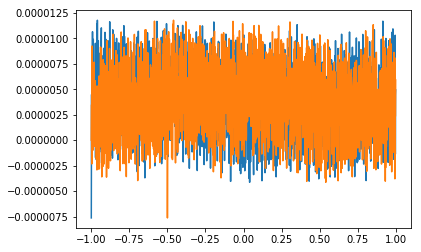

In [18]:
plt.plot(np.arange(-1,1,.001),
         np.cos(np.arange(-1,1,.001)*np.pi)-np.array([fp_phase2cossin(p).real for p in np.arange(-1,1,.001)]))
plt.plot(np.arange(-1,1,.001),
         np.sin(np.arange(-1,1,.001)*np.pi)-np.array([fp_phase2cossin(p).imag for p in np.arange(-1,1,.001)]));

Do double precision matlab calcs

In [42]:
#Matlab data still needs the FFT
mlab_pfb=np.fft.fftshift(np.fft.fft(matlab_sim_out.reshape(matlab_sim_out.shape[0], n_bin), axis=1),1)

#Matlab PFB output
mlab=mlab_pfb[:tu.n_packets_rcvd, strt_bins]
phasemlab=(toneincs[:mlab.shape[1],np.newaxis]*np.arange(mlab.shape[0]) + phase0s[:mlab.shape[1],np.newaxis]).T

# #Also do the DDC on the matlab data
ddsv = np.cos(phasemlab*np.pi)+np.sin(phasemlab*np.pi)*1j
ddcd=ddc_mlab(mlab, ddsv, lowpass=True)

Load cache of or do the fixed point calcs

In [20]:
data=packets_out  # [sample, resonator]

In [21]:
if not os.path.exists('testchan_cache.npz'):
    fpcomb16_15=fparray(comb, FP16_15)
    fpcoeff16_26=fparray(coeffs, FP16_26)
    pfb_fp16=do_fixed_point_pfb(fpcomb16_15, fpcoeff16_26)
    fp_opfb=np.fft.fft(pfb_fp16.reshape(pfb_fp16.shape[0], n_bin), axis=1) #shifting here causes problems for plotting

    #Get DDS values for fixed point
    fp_biniq=fp_opfb[:tu.n_packets_rcvd,shft_bins] #fftshift is required here
    fp_phase=fp_phases(toneincs[:fp_biniq.shape[1]],phase0s[:fp_biniq.shape[1]],fp_biniq.shape[0], i0=18)  #more accuate than reality by a bit
    fp_ddsv=np.array([list(map(fp_phase2cossin, p)) for p in fp_phase.T]).T
    fp_ddsv=fparray(fp_ddsv, FP18_17)
    fp_biniq=fparray(fp_biniq, FP16_25)

    #Do the DDC
    fp_ddcd=fp_cmpy(fp_biniq, fp_ddsv)
    fp_ddcd=fparray(fp_ddcd, lambda x: FpBinary(-7,23,True,x))

    #Back to floating
    fp_ddsv = fp_ddsv[:,:,0].astype(float)+1j*fp_ddsv[:,:,1].astype(float)
    fp_biniq = fp_biniq[:,:,0].astype(float)+1j*fp_biniq[:,:,1].astype(float)
    fp_ddcd = fp_ddcd[:,:,0].astype(float)+1j*fp_ddcd[:,:,1].astype(float)
    fp_opfb = fp_opfb[:,:,0].astype(float)+1j*fp_opfb[:,:,1].astype(float)

    np.savez('testchan_cache.npz', fp_ddsv=fp_ddsv, fp_ddcd=fp_ddcd, fp_biniq=fp_biniq, fp_opfb=fp_opfb)
else:
    with np.load('testchan_cache.npz') as d:
        fp_ddsv=d['fp_ddsv']
        fp_ddcd=d['fp_ddcd']
        fp_biniq=d['fp_biniq']
        fp_opfb=d['fp_opfb']

Matlab plots

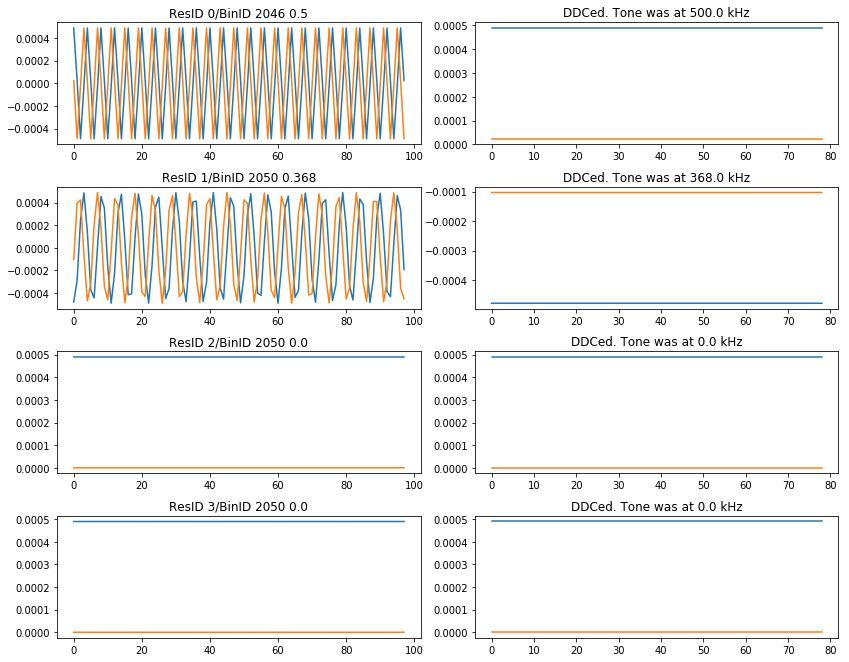

In [43]:
_,axes = plt.subplots(mlab.shape[1],2,figsize=(14,2.83*mlab.shape[1]))
for i,(raw,ddc) in enumerate(zip(mlab.T,ddcd.T)):
    plt.sca(axes[i,0])
    plt.plot(raw.real)
    plt.plot(raw.imag)
    plt.title(f"ResID {i}/BinID {bins[i]} {toneincs[i]}")
    plt.sca(axes[i,1])
    plt.plot(ddc.real)
    plt.plot(ddc.imag)
    plt.title(f"DDCed. Tone was at {toneincs[i]*1e3} kHz")
plt.subplots_adjust(wspace=.15, hspace=.35)

Fixed point simulation plots

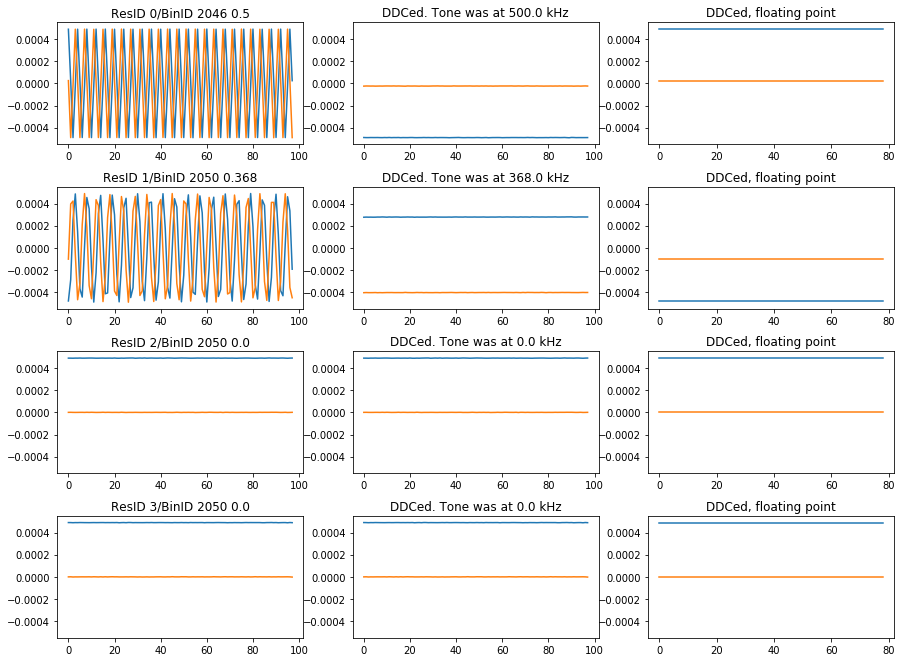

In [45]:
lim=(-.00055,.00055)
_,axes = plt.subplots(fp_biniq.shape[1],3,figsize=(15,2.83*fp_biniq.shape[1]))
for i,(a,b,c) in enumerate(zip(fp_biniq[:tu.n_packets_rcvd].T,fp_ddcd[:tu.n_packets_rcvd].T,
                                ddcd.T)):
    plt.sca(axes[i,0])
    plt.plot(a.real)
    plt.plot(a.imag)
    plt.ylim(*lim)
    plt.title(f"ResID {i}/BinID {bins[i]} {toneincs[i]}")
    plt.sca(axes[i,1])
    plt.plot(b.real)
    plt.plot(b.imag)
    plt.ylim(*lim)
    plt.title(f"DDCed. Tone was at {toneincs[i]*1e3} kHz")
    plt.sca(axes[i,2])
    plt.plot(c.real)
    plt.plot(c.imag)
    plt.title('DDCed, floating point')
    plt.ylim(*lim)
plt.subplots_adjust(wspace=.2, hspace=.35)

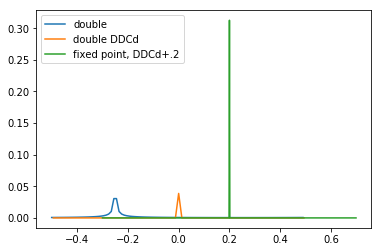

In [24]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(mlab.shape[0])),np.fft.fftshift(np.abs(np.fft.fft(mlab[:,0]))),
        label='double')
plt.plot(np.fft.fftshift(np.fft.fftfreq(ddcd.shape[0])),np.fft.fftshift(np.abs(np.fft.fft(ddcd[:,0]))),
        label='double DDCd')
plt.plot(np.fft.fftshift(np.fft.fftfreq(fp_ddcd.shape[0]))+.2,np.fft.fftshift(np.abs(np.fft.fft(fp_ddcd[:,0]))),
        label='fixed point, DDCd+.2')
plt.legend();

Try and isolate the first valid output

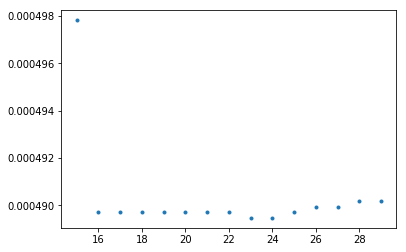

In [25]:
plt.plot(np.arange(15,30),data.imag[15:30,2],'.');

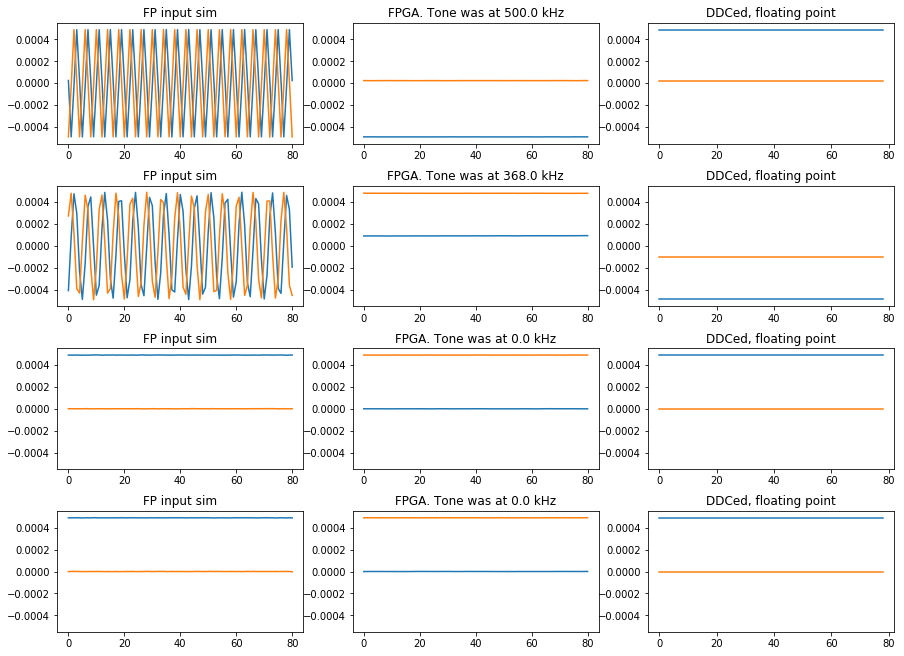

In [58]:
lim=(-.00055,.00055)
res_plot=shft_bins#9,1023,1024,2047]  #which channels to plot
_,axes = plt.subplots(len(res_plot),3,figsize=(15,2.8*len(res_plot)))
for i,(rID, a,b, c) in enumerate(zip(res_plot, 
                                      fp_biniq[first_good_packet:tu.n_packets_rcvd].T, 
                                      data[first_good_packet:tu.n_packets_rcvd,:4].T,
                                      ddcd[:tu.n_packets_rcvd].T)):
    plt.sca(axes[i,0])
    plt.plot(a.real)
    plt.plot(a.imag)
    plt.ylim(*lim)
    plt.title(f"FP input sim")
    plt.sca(axes[i,1])
    plt.plot(b.real)
    plt.plot(b.imag)
    plt.ylim(*lim)
    plt.title(f"FPGA. Tone was at {toneincs[i]*1e3} kHz")
    plt.sca(axes[i,2])
    plt.plot(c.real)
    plt.plot(c.imag)
    plt.title('DDCed, floating point')
    plt.ylim(*lim)
plt.subplots_adjust(wspace=.2, hspace=.35)

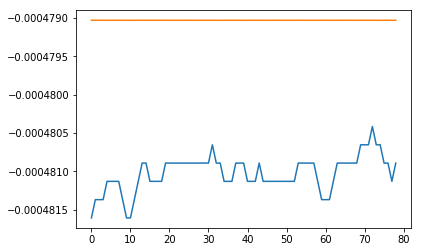

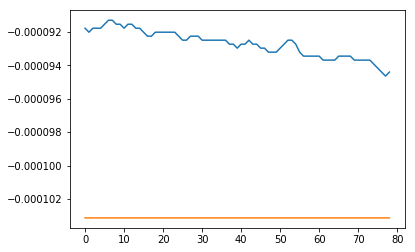

In [73]:
plt.plot((1j*data[first_good_packet+2:tu.n_packets_rcvd,1]).real)
plt.plot(ddcd[:tu.n_packets_rcvd,1].real)
plt.figure()
plt.plot((-1j*data[first_good_packet+2:tu.n_packets_rcvd,1]).imag)
plt.plot(ddcd[:tu.n_packets_rcvd,1].imag)

#,ddcd[:tu.n_packets_rcvd,1]